In [1]:
import os
import torch
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import fft, fftpack
from scipy.ndimage import zoom
from random import randrange
import re
import importlib
import h5py

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Jupyter inline plotting
%matplotlib inline

# Custom metrics
from metrics import calc_NRMSE as nrmse
from metrics import calc_SSIM as ssim

# Reconstruction utilities
from ulf_recon_fns import ulfl1recon, applyMask, poissonDiscSigpy, find_lamda_mask, find_iter_mask, coil_combine, awgn
import swin_fns
import automap_fns
import unrolling_fns

/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
2026-01-13 11:54:07.958783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 11:54:09.443530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:


# R = 4 # acceleration factor
# calib_size = 10

# loss_fn = 'mse'
# #loss_fn = 'perceptual'

file_phantom_FS = 'data/volunteer_20240711/20240711_run4_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_FS_NA48_ActiveTxPlusBothRxs_HeadPhantom_GlobalShims.mat'
file_phantom_R2 = 'data/volunteer_20240711/20240711_run5_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R2_NA48_ActiveTxPlusBothRxs_HeadPhantom_GlobalShims.mat'
file_phantom_R4 = 'data/volunteer_20240711/20240711_run6_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R4_NA48_ActiveTxPlusBothRxs_HeadPhantom_GlobalShims.mat'

file_brain_FS = 'data/volunteer_20240711/20240711_run8_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_FS_NA64_ActiveTxPlusBothRxs_Head_GlobalShims.mat'
file_brain_R2 = 'data/volunteer_20240711/20240711_run9_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R2_NA64_ActiveTxPlusBothRxs_Head_GlobalShims.mat'
file_brain_R4 = 'data/volunteer_20240711/20240711_run10_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R4_NA64_ActiveTxPlusBothRxs_Head_GlobalShims.mat'


def ksp_load(filename):
    data = loadmat(filename)
    ksp_shp = data['i_kspace'].shape

    print(ksp_shp)
    
    if len(ksp_shp) > 3:
        ksp = np.moveaxis(data['i_kspace'],3,0)
    else:
        ksp = np.reshape(data['i_kspace'],(1,ksp_shp[0],ksp_shp[1],ksp_shp[2]))

    ksp = ksp[1,:,:,:]
    ksp = ksp[np.newaxis,:]

    return ksp   

In [3]:
def recon_prospective_us( ksp, R, recon_method = 'ifft', lamda_opt=0.001, iter_opt = 30):
    #scaling data

    img_rss = np.sum(np.abs(sp.ifft(ksp, axes=(-1, -2, -3)))**2, axis=0)**0.5
    volumeZFrss = img_rss
    
    # scaling all numbers to sensible values from the beginning
    scale_factor = np.percentile(abs(volumeZFrss),95) 
    kspZFscaled = ksp/scale_factor
    
    yshift = -2
    kspZFscaled = np.roll(kspZFscaled,(0,yshift,0),axis=(1,2,3))
    
    
    
    if kspZFscaled.shape[0] == 1:
        mps = np.ones(kspZFscaled.shape,dtype=complex)
    else:
        mps = mr.app.EspiritCalib(kspZFscaled, calib_width=20, kernel_width=6, show_pbar=True).run()
    #mps = np.ones(kspZFscaled.shape)
    img_fs = sp.ifft(kspZFscaled, axes=(-1, -2, -3))
    volumeZFscaled = coil_combine(img_fs,mps)

    #if R==1 or recon_method == 'zerofill':
        
    #else:
    mask = (np.abs(kspZFscaled[0,:,32,:]) > 0 )

    kspInput = kspZFscaled

    match recon_method:
        case 'ifft':
            return volumeZFscaled, scale_factor
        case 'cs':
            volcsrecon = ulfl1recon(kspInput,mask,lamda_opt,iter_opt,mps)
            return volcsrecon, scale_factor
        case 'automap':
            if R==2:
              model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
              model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
            elif R==4:
              model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
              model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'
            volamaprecon, volamaprecon_mc = automap_fns.automapRecon(kspInput,mps,model_real_dir,model_imag_dir)
            volamaprecon = volamaprecon
            return volamaprecon, scale_factor
        case 'unrolled':
            if R==2:
                unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R2.pth'
            elif R==4:
                unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R4.pth'
            _, volunrollrecon = unrolling_fns.unrollingRecon(kspInput,mask,mps, unroll_model_pth)
            return volunrollrecon, scale_factor
        case 'swincascade':
            if R==2:
                model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R2.pth'
            elif R==4:
                model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R4.pth'
            model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device)
            volswinrecon, _ = swin_fns.swinRecon(kspInput, mask, model_swin, device=device)
            return volswinrecon, scale_factor
 

In [4]:
# --- Phantom Reconstructions ---

# R = 1 (Fully sampled)
ksp = ksp_load(file_phantom_FS)
phantom_R1_GT, _ = recon_prospective_us(ksp, R=1, recon_method='ifft')

# R = 2
ksp = ksp_load(file_phantom_R2)
phantom_R2_zf, _ = recon_prospective_us(ksp, R=2, recon_method='ifft')
phantom_R2_cs, _ = recon_prospective_us(ksp, R=2, recon_method='cs', lamda_opt=0.05, iter_opt=10)
phantom_R2_amap, _ = recon_prospective_us(ksp, R=2, recon_method='automap')
phantom_R2_unroll, _ = recon_prospective_us(ksp, R=2, recon_method='unrolled')
phantom_R2_swin, _ = recon_prospective_us(ksp, R=2, recon_method='swincascade')

# R = 4
ksp = ksp_load(file_phantom_R4)
phantom_R4_zf, _ = recon_prospective_us(ksp, R=4, recon_method='ifft')
phantom_R4_cs, _ = recon_prospective_us(ksp, R=4, recon_method='cs', lamda_opt=0.02, iter_opt=50)
phantom_R4_amap, _ = recon_prospective_us(ksp, R=4, recon_method='automap')
phantom_R4_unroll, _ = recon_prospective_us(ksp, R=4, recon_method='unrolled')
phantom_R4_swin, _ = recon_prospective_us(ksp, R=4, recon_method='swincascade')


# --- Brain Reconstructions ---

# R = 1 (Fully sampled)
ksp = ksp_load(file_brain_FS)
brain_R1_GT, _ = recon_prospective_us(ksp, R=1, recon_method='ifft')

# R = 2
ksp = ksp_load(file_brain_R2)
brain_R2_zf, _ = recon_prospective_us(ksp, R=2, recon_method='ifft')
brain_R2_cs, _ = recon_prospective_us(ksp, R=2, recon_method='cs', lamda_opt=0.05, iter_opt=10)
brain_R2_amap, _ = recon_prospective_us(ksp, R=2, recon_method='automap')
brain_R2_unroll, _ = recon_prospective_us(ksp, R=2, recon_method='unrolled')
brain_R2_swin, _ = recon_prospective_us(ksp, R=2, recon_method='swincascade')

# R = 4
ksp = ksp_load(file_brain_R4)
brain_R4_zf, _ = recon_prospective_us(ksp, R=4, recon_method='ifft')
brain_R4_cs, _ = recon_prospective_us(ksp, R=4, recon_method='cs', lamda_opt=0.05, iter_opt=10)
brain_R4_amap, _ = recon_prospective_us(ksp, R=4, recon_method='automap')
brain_R4_unroll, _ = recon_prospective_us(ksp, R=4, recon_method='unrolled')
brain_R4_swin, _ = recon_prospective_us(ksp, R=4, recon_method='swincascade')


(75, 64, 25, 2)
(75, 64, 25, 2)


2026-01-13 11:54:13.299004: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-13 11:54:13.299073: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: autobeast
2026-01-13 11:54:13.299088: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: autobeast
2026-01-13 11:54:13.299182: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 580.95.5
2026-01-13 11:54:13.299233: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 575.64.3
2026-01-13 11:54:13.299248: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 575.64.3 does not match DSO version 580.95.5 -- cannot find working devices in this configuration
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasa

(75, 64, 25, 2)
(75, 64, 25, 2)
(75, 64, 25, 2)
(75, 64, 25, 2)


In [5]:
# --- Phantom grouped reconstructions ---
phantom_vols_R2 = [
    phantom_R1_GT,    # GT for R=2 comparisons
    phantom_R2_zf,
    phantom_R2_cs,
    phantom_R2_amap,
    phantom_R2_unroll,
    phantom_R2_swin
]

phantom_vols_R4 = [
    None,             # No GT for R=4
    phantom_R4_zf,
    phantom_R4_cs,
    phantom_R4_amap,
    phantom_R4_unroll,
    phantom_R4_swin
]

# --- Brain grouped reconstructions ---
brain_vols_R2 = [
    brain_R1_GT,      # GT for R=2 comparisons
    brain_R2_zf,
    brain_R2_cs,
    brain_R2_amap,
    brain_R2_unroll,
    brain_R2_swin
]

brain_vols_R4 = [
    None,             # No GT for R=4
    brain_R4_zf,
    brain_R4_cs,
    brain_R4_amap,
    brain_R4_unroll,
    brain_R4_swin
]


In [6]:
def plot_recons_both(axs, GT_phantom, vols_R2_phantom, vols_R4_phantom,
                     GT_brain, vols_R2_brain, vols_R4_brain,
                     titles, slc_phantom, slc_brain, asp_ratio,
                     max_GT_phantom, max_GT_brain,
                     phantom_thresh=0.17, brain_thresh=0.15):
    """
    Displays masked volumes (background zeroed for visualization),
    computes SSIM/NRMSE on masked copies,
    and BRISQUE/TG on unmasked volumes.
    Inputs are never modified.
    """
    from metrics import brisque_volume_3d, tenengrad_volume_3d

    # --- build masks from GT ---
    phantom_mask = np.ma.getmask(np.ma.masked_less(np.abs(GT_phantom), phantom_thresh))
    brain_mask   = np.ma.getmask(np.ma.masked_less(np.abs(GT_brain),   brain_thresh))

    def masked_copy(vol, mask):
        v = np.abs(vol).copy()
        v[mask] = 0
        return v

    for col in range(len(titles)):
        # ---------------------- Phantom R=2 ----------------------
        img_r2_phantom = masked_copy(vols_R2_phantom[col], phantom_mask)
        axs[0, col].imshow(img_r2_phantom[:, :, slc_phantom].T,
                           cmap='gray', vmin=0, vmax=1.05 * max_GT_phantom)

        if col == 0:
            axs[0, col].set_title(f'(a) {titles[col]}', fontweight='bold')
            axs[2, col].set_title(f'(b) {titles[col]}', fontweight='bold')
        else:
            axs[0, col].set_title(titles[col], fontweight='bold')
            axs[2, col].set_title(titles[col], fontweight='bold')

        axs[0, col].set_aspect(asp_ratio)
        axs[0, col].set_xticks([]); axs[0, col].set_yticks([])

        if col == 0:
            bq = brisque_volume_3d(GT_phantom, axis=2, clip_percentiles=(10, 90))[0]
            tg = tenengrad_volume_3d(GT_phantom, axis=2, clip_percentiles=(10, 90))[0]
            #axs[0, col].set_xlabel(f'BRISQUE = {bq:.2f}\nTG = {tg:.4f}')
        else:
            gt_m = masked_copy(GT_phantom, phantom_mask)
            r2_m = masked_copy(vols_R2_phantom[col], phantom_mask)
            axs[0, col].set_xlabel(
                f'SSIM* = {ssim(r2_m, gt_m):.2f}\n'
                f'NRMSE* = {nrmse(r2_m, gt_m):.3f}\n'
                f'BRISQUE = {brisque_volume_3d(vols_R2_phantom[col], axis=2, clip_percentiles=(10, 90))[0]:.2f}\n'
                f'TG = {tenengrad_volume_3d(vols_R2_phantom[col], axis=2, clip_percentiles=(10, 90))[0]:.4f}'
            )
            if col == 1:
                axs[0, col].set_ylabel('R = 2', fontsize=11, fontweight='bold')

        # ---------------------- Phantom R=4 ----------------------
        if col > 0:
            img_r4_phantom = masked_copy(vols_R4_phantom[col], phantom_mask)
            axs[1, col].imshow(img_r4_phantom[:, :, slc_phantom].T,
                               cmap='gray', vmin=0, vmax=1.05 * max_GT_phantom)
            axs[1, col].set_aspect(asp_ratio)
            axs[1, col].set_xticks([]); axs[1, col].set_yticks([])

            gt_m = masked_copy(GT_phantom, phantom_mask)
            r4_m = masked_copy(vols_R4_phantom[col], phantom_mask)
            axs[1, col].set_xlabel(
                f'SSIM* = {ssim(r4_m, gt_m):.2f}\n'
                f'NRMSE* = {nrmse(r4_m, gt_m):.3f}\n'
                f'BRISQUE = {brisque_volume_3d(vols_R4_phantom[col], axis=2, clip_percentiles=(10, 90))[0]:.2f}\n'
                f'TG = {tenengrad_volume_3d(vols_R4_phantom[col], axis=2, clip_percentiles=(10, 90))[0]:.4f}'
            )
            if col == 1:
                axs[1, col].set_ylabel('R = 4', fontsize=11, fontweight='bold')

        # ---------------------- Brain R=2 ------------------------
        img_r2_brain = masked_copy(vols_R2_brain[col], brain_mask)
        axs[2, col].imshow(img_r2_brain[:, :, slc_brain].T,
                           cmap='gray', vmin=0, vmax=1.05 * max_GT_brain)
        axs[2, col].set_aspect(asp_ratio)
        axs[2, col].set_xticks([]); axs[2, col].set_yticks([])

        if col == 0:
            bq = brisque_volume_3d(GT_brain, axis=2, clip_percentiles=(10, 90))[0]
            tg = tenengrad_volume_3d(GT_brain, axis=2, clip_percentiles=(10, 90))[0]
            #axs[2, col].set_xlabel(f'BRISQUE = {bq:.2f}\nTG = {tg:.4f}')
        else:
            gt_m = masked_copy(GT_brain, brain_mask)
            r2_m = masked_copy(vols_R2_brain[col], brain_mask)
            axs[2, col].set_xlabel(
                f'SSIM* = {ssim(r2_m, gt_m):.2f}\n'
                f'NRMSE* = {nrmse(r2_m, gt_m):.3f}\n'
                f'BRISQUE = {brisque_volume_3d(vols_R2_brain[col], axis=2, clip_percentiles=(10, 90))[0]:.2f}\n'
                f'TG = {tenengrad_volume_3d(vols_R2_brain[col], axis=2, clip_percentiles=(10, 90))[0]:.4f}'
            )
            if col == 1:
                axs[2, col].set_ylabel('R = 2', fontsize=11, fontweight='bold')

        # ---------------------- Brain R=4 ------------------------
        if col > 0:
            img_r4_brain = masked_copy(vols_R4_brain[col], brain_mask)
            axs[3, col].imshow(img_r4_brain[:, :, slc_brain].T,
                               cmap='gray', vmin=0, vmax=1.05 * max_GT_brain)
            axs[3, col].set_aspect(asp_ratio)
            axs[3, col].set_xticks([]); axs[3, col].set_yticks([])

            gt_m = masked_copy(GT_brain, brain_mask)
            r4_m = masked_copy(vols_R4_brain[col], brain_mask)
            axs[3, col].set_xlabel(
                f'SSIM* = {ssim(r4_m, gt_m):.2f}\n'
                f'NRMSE* = {nrmse(r4_m, gt_m):.3f}\n'
                f'BRISQUE = {brisque_volume_3d(vols_R4_brain[col], axis=2, clip_percentiles=(10, 90))[0]:.2f}\n'
                f'TG = {tenengrad_volume_3d(vols_R4_brain[col], axis=2, clip_percentiles=(10, 90))[0]:.4f}'
            )
            if col == 1:
                axs[3, col].set_ylabel('R = 4', fontsize=11, fontweight='bold')

    # Hide empty GT cells (R=4)
    axs[1, 0].axis('off'); axs[3, 0].axis('off')

    # Styling / layout
    for ax in axs.flatten():
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_aspect(asp_ratio)
        ax.tick_params(color='k')
        for spine in ax.spines.values():
            spine.set_edgecolor('k')

    shift_down = -0.03
    for k in range(len(titles)):
        for j in [2, 3]:
            l, b, w, h = axs[j, k].get_position().bounds
            axs[j, k].set_position([l, b - shift_down, w, h])

    return axs


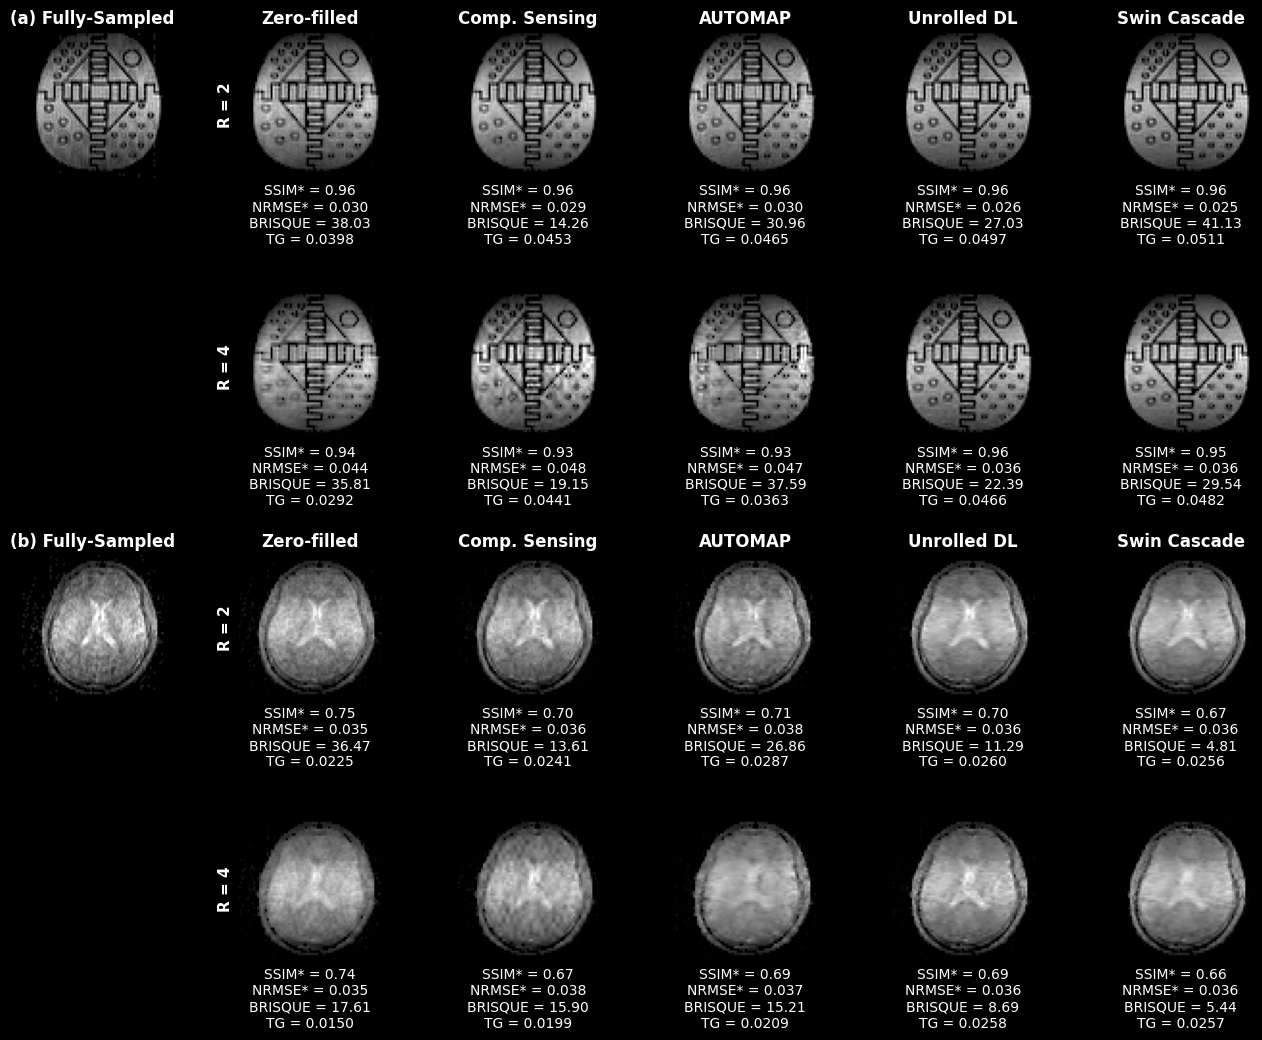

In [7]:
# --- Setup shared titles and volume arrays ---
titles = ['Fully-Sampled', 'Zero-filled', 'Comp. Sensing', 'AUTOMAP', 'Unrolled DL', 'Swin Cascade']
asp_ratio = (phantom_R4_zf.shape[1] * 3.5) / (phantom_R4_zf.shape[0] * 2.5)

slc_phantom=16
slc_brain=17
max_GT_phantom = np.amax(np.abs(phantom_R4_zf[:, :, slc_phantom]))
max_GT_brain = np.amax(np.abs(brain_R4_zf[:, :, slc_brain]))

plt.style.use('dark_background')
fig, axs = plt.subplots(4, 6, figsize=(13, 10))
axs = plot_recons_both(axs,
                       phantom_R1_GT, phantom_vols_R2, phantom_vols_R4,
                       brain_R1_GT, brain_vols_R2, brain_vols_R4,
                       titles, slc_phantom, slc_brain,
                       asp_ratio, max_GT_phantom, max_GT_brain)


plt.tight_layout()
plt.show()

fig.savefig('export_figs/prospective_ulf_recon.pdf', bbox_inches='tight', dpi=300)

In [8]:
ksp_fs_ph = ksp_load(file_phantom_FS)
vol_fs_ph, _ = recon_prospective_us(ksp_fs_ph, R=1, recon_method='ifft')
vol_fs_ph_mag = np.abs(vol_fs_ph).astype(np.float64)

ksp_fs_br = ksp_load(file_brain_FS)
vol_fs_br, _ = recon_prospective_us(ksp_fs_br, R=1, recon_method='ifft')
vol_fs_br_mag = np.abs(vol_fs_br).astype(np.float64)

(75, 64, 25, 2)
(75, 64, 25, 2)


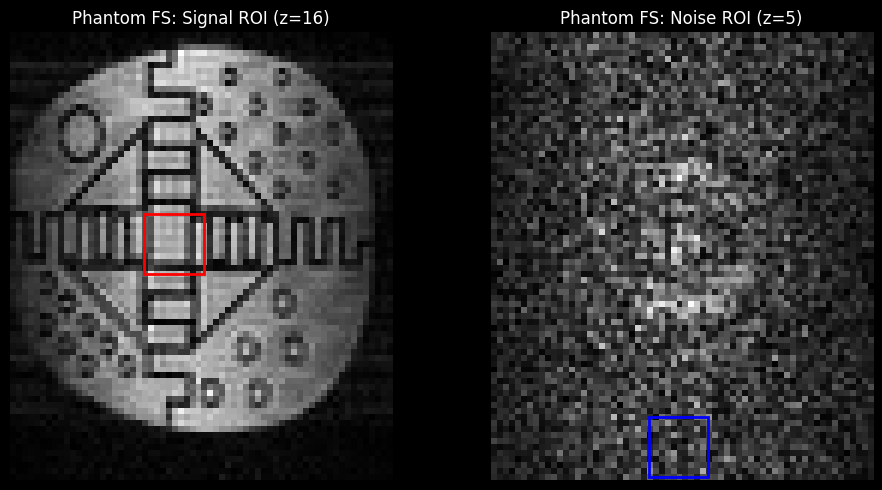

Phantom SNR: 22.74 (27.14 dB)


In [9]:
from snr_calc import snr_from_volume

# assuming vol_fs_ph_mag is your magnitude volume (np.ndarray)
snr_lin, snr_db, sig_mean, noi_std, sig_org, noi_org = snr_from_volume(
    vol_fs_ph_mag,
    cube_size=10,
    signal_origin=(34, 22, 11),  # or None for centered cube
    noise_origin=(0, 26, 0),
    plot=True,
    dataset_name="Phantom FS"
)

print(f"Phantom SNR: {snr_lin:.2f} ({snr_db:.2f} dB)")

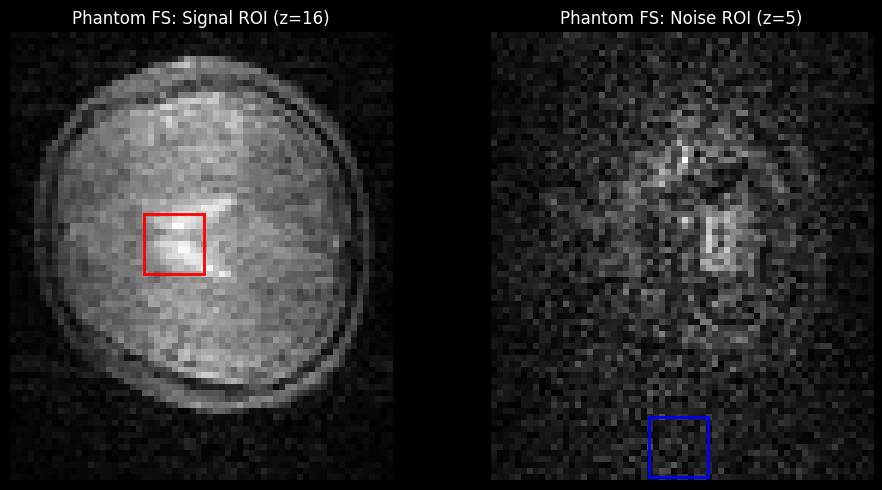

Brain SNR: 19.09 (25.62 dB)


In [10]:

snr_lin, snr_db, sig_mean, noi_std, sig_org, noi_org = snr_from_volume(
    vol_fs_br_mag,
    cube_size=10,
    signal_origin=(34, 22, 11),  # or None for centered cube
    noise_origin=(0, 26, 0),
    plot=True,
    dataset_name="Phantom FS"
)

print(f"Brain SNR: {snr_lin:.2f} ({snr_db:.2f} dB)")